Імпорт бібліотек:

In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
import tensorflow as tf
import cv2
import os
from glob import glob
pyplot.rcParams['figure.figsize'] = [15, 10]

Перелік версій бібліотек, на яких виконано роботу, для вирішень проблем сумісності:

In [2]:
print(f'numpy     : {numpy.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'opencv    : {cv2.__version__}')

numpy     : 1.26.4
matplotlib: 3.9.2
tensorflow: 2.10.1
opencv    : 4.10.0


### Stage 1

Preparate data

In [3]:
database_folder = './data/PetImages/'
cats_folder = os.path.join(database_folder, 'Cat')
dogs_folder = os.path.join(database_folder, 'Dog')

def load_to_mem_images(folder_name: str = None) -> list:
    images = list()
    filenames = glob(folder_name+'/*.jpg')
    for filename in filenames:
        img = cv2.imread(filename=filename)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except:
            print(f'Error of load "{filename}" image!')
        else:
            img = cv2.resize(src=img, dsize=(224, 224))
            img = img.astype(dtype=numpy.float32)/img.max()
            images.append(img)
    return numpy.array(images)
#Control path to images:
print(cats_folder)
print(dogs_folder)

./data/PetImages/Cat
./data/PetImages/Dog


In [4]:
### Loading images to RAM:
cats_list = load_to_mem_images(folder_name=cats_folder)
cats_count = len(cats_list)
print(f'Cats count in dataset {cats_count}')

Error of load "./data/PetImages/Cat\10125.jpg" image!
Error of load "./data/PetImages/Cat\10404.jpg" image!
Error of load "./data/PetImages/Cat\10501.jpg" image!
Error of load "./data/PetImages/Cat\10820.jpg" image!
Error of load "./data/PetImages/Cat\11210.jpg" image!
Error of load "./data/PetImages/Cat\11565.jpg" image!
Error of load "./data/PetImages/Cat\11874.jpg" image!
Error of load "./data/PetImages/Cat\11935.jpg" image!
Error of load "./data/PetImages/Cat\140.jpg" image!
Error of load "./data/PetImages/Cat\2663.jpg" image!
Error of load "./data/PetImages/Cat\3300.jpg" image!
Error of load "./data/PetImages/Cat\3491.jpg" image!
Error of load "./data/PetImages/Cat\4833.jpg" image!
Error of load "./data/PetImages/Cat\5553.jpg" image!
Error of load "./data/PetImages/Cat\660.jpg" image!
Error of load "./data/PetImages/Cat\666.jpg" image!
Error of load "./data/PetImages/Cat\7968.jpg" image!
Error of load "./data/PetImages/Cat\7978.jpg" image!
Error of load "./data/PetImages/Cat\8470.

In [5]:
dogs_list = load_to_mem_images(folder_name=dogs_folder)
dogs_count = len(dogs_list)
print(f'Dogs count in dataset {dogs_count}')

Error of load "./data/PetImages/Dog\10158.jpg" image!
Error of load "./data/PetImages/Dog\10401.jpg" image!
Error of load "./data/PetImages/Dog\10747.jpg" image!
Error of load "./data/PetImages/Dog\10797.jpg" image!
Error of load "./data/PetImages/Dog\11410.jpg" image!
Error of load "./data/PetImages/Dog\11675.jpg" image!
Error of load "./data/PetImages/Dog\11702.jpg" image!
Error of load "./data/PetImages/Dog\11849.jpg" image!
Error of load "./data/PetImages/Dog\11853.jpg" image!
Error of load "./data/PetImages/Dog\1308.jpg" image!
Error of load "./data/PetImages/Dog\1866.jpg" image!
Error of load "./data/PetImages/Dog\2384.jpg" image!
Error of load "./data/PetImages/Dog\2688.jpg" image!
Error of load "./data/PetImages/Dog\2877.jpg" image!
Error of load "./data/PetImages/Dog\3136.jpg" image!
Error of load "./data/PetImages/Dog\3288.jpg" image!
Error of load "./data/PetImages/Dog\3588.jpg" image!
Error of load "./data/PetImages/Dog\4367.jpg" image!
Error of load "./data/PetImages/Dog\5

In [6]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-feature-vector/2",
                   trainable=False),  
    tf.keras.layers.Dense(2, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42626560  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 42,630,658
Trainable params: 4,098
Non-trainable params: 42,626,560
_________________________________________________________________


### Annotation
Error in uploaded images: The images are encoded as a GIF file but have an extension of JPG

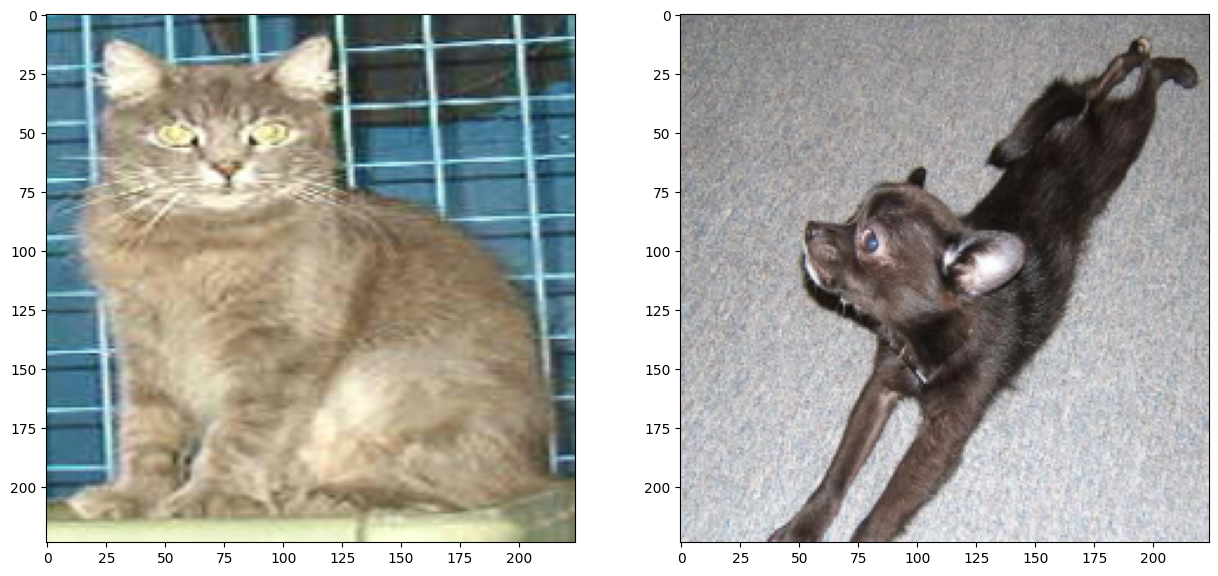

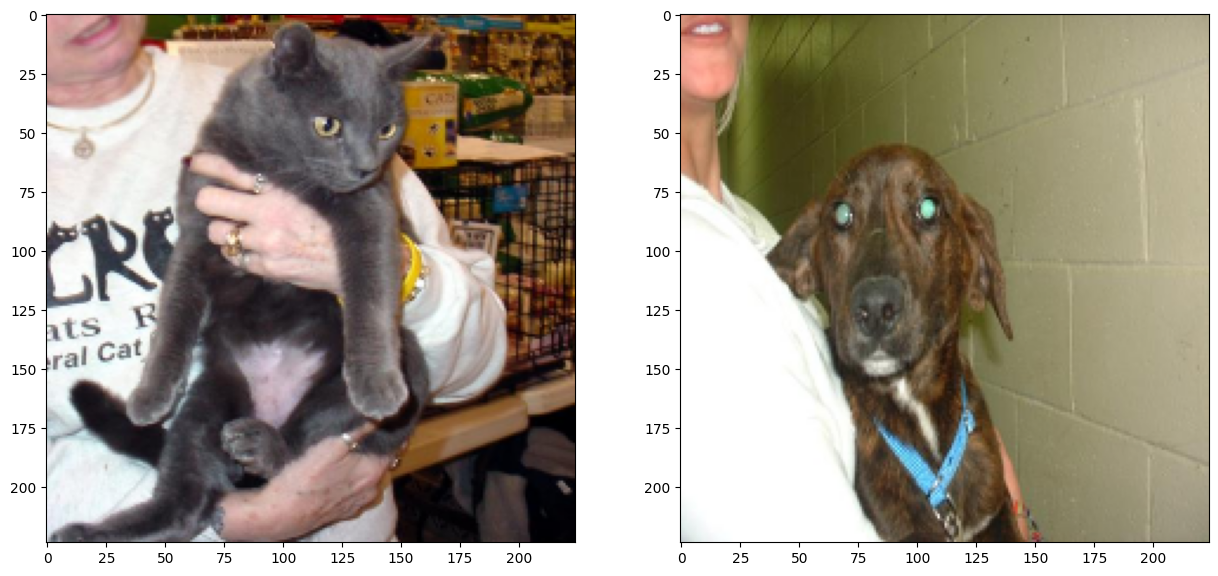

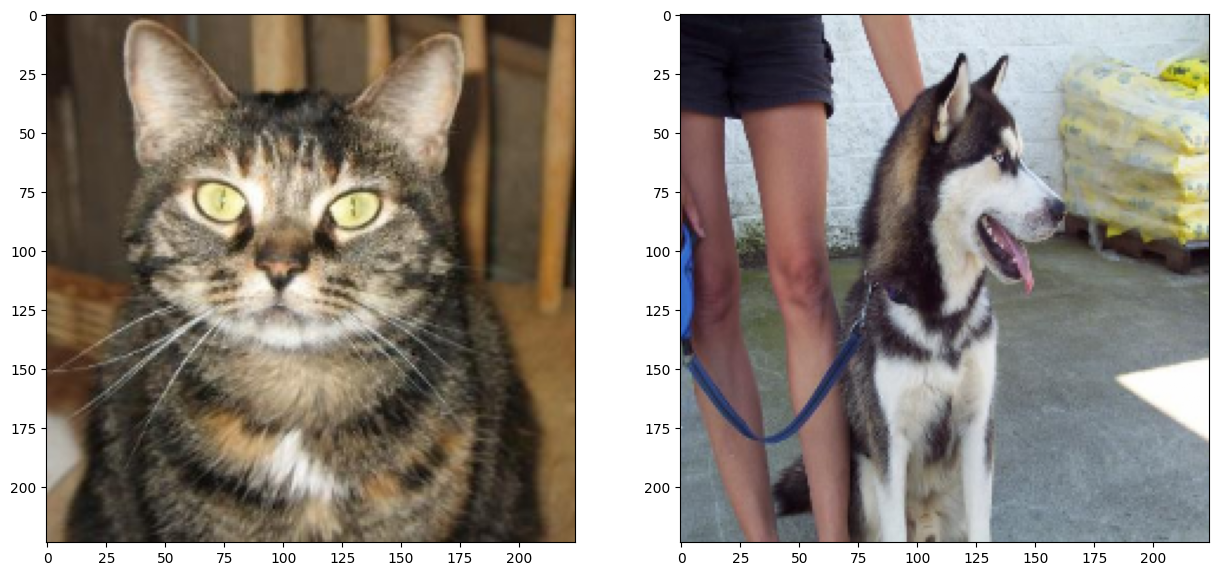

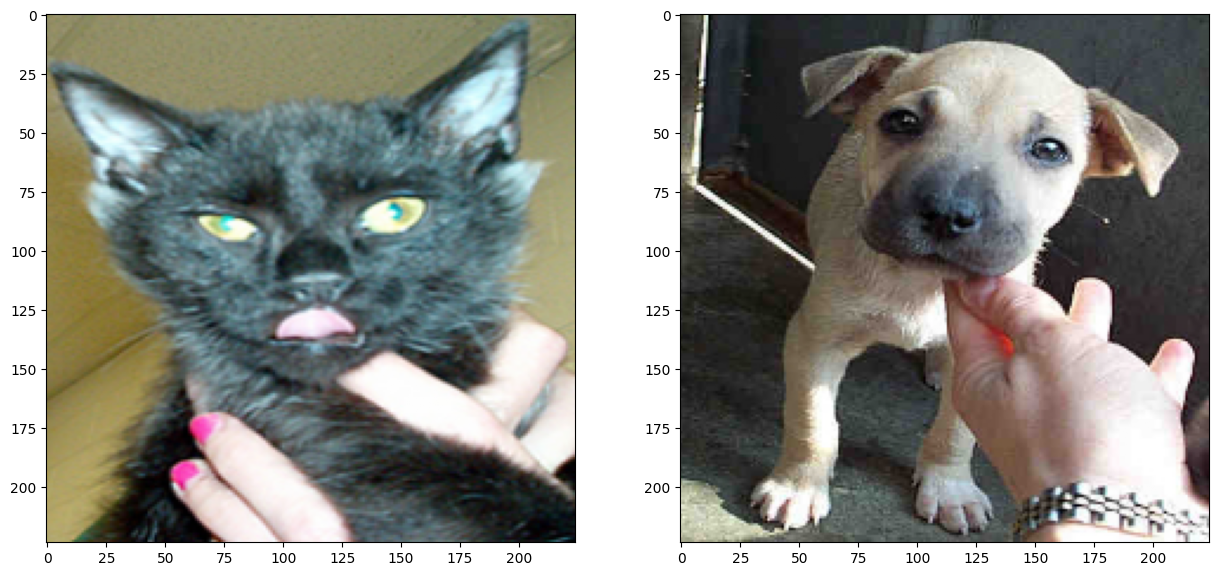

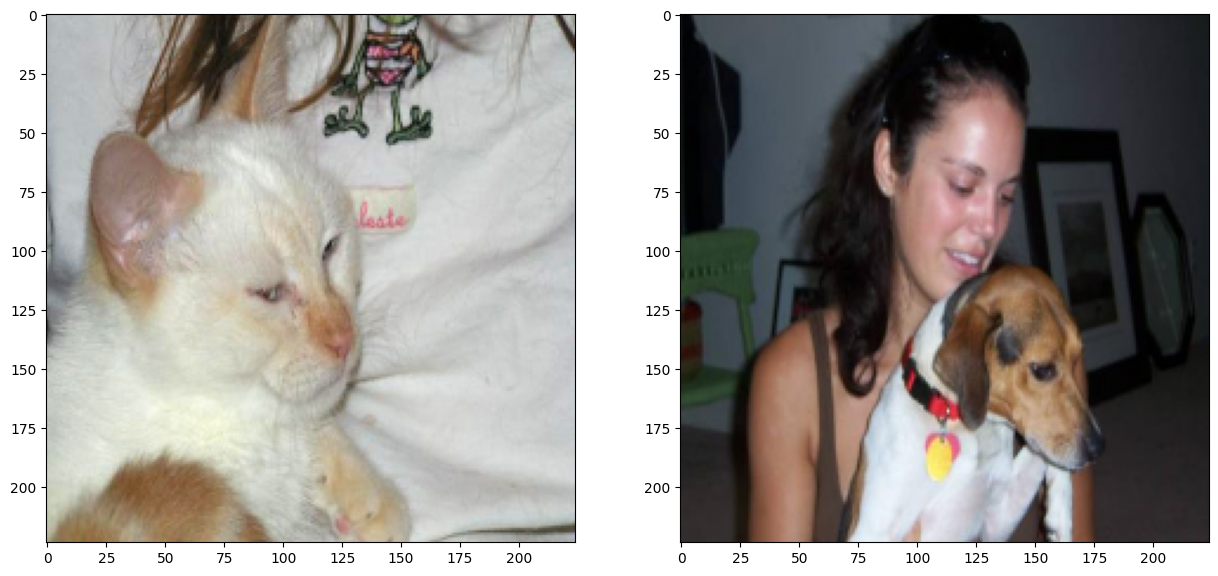

In [9]:
# # Output exapmles images for database:
for _ in range(5):
    pyplot.subplot(1, 2, 1), pyplot.imshow(cats_list[numpy.random.randint(0, cats_count)])
    pyplot.subplot(1, 2, 2), pyplot.imshow(dogs_list[numpy.random.randint(0, dogs_count)])
    pyplot.show()

# for images, labels in data_training.take(1):
#   for i in range(5):
#     pyplot.imshow(images[i].numpy().astype(numpy.uint8))
#     pyplot.title(class_names[labels[i]])
#     pyplot.axis("off")
#     pyplot.show()

### Build data generator with annotation functions

In [10]:
def data_generator(cats_list: list, dogs_list: list, bathsize=10):
    random_zoom = tf.keras.layers.RandomZoom(height_factor=[-0.1, 0.1])
    random_flip = tf.keras.layers.RandomFlip('horizontal')
    # resizer     = tf.keras.layers.Resizing(height=256, width=256, interpolation='bilinear')
    cats_count = len(cats_list)
    dogs_count = len(dogs_list)
    data_count = cats_count+dogs_count
    pernumeration = numpy.random.permutation(data_count)
    idx = 0
    while True:
        y_data_l = list()
        x_data_l = list()
        for _ in range(bathsize):
            its_cat = pernumeration[idx]<cats_count
            if its_cat:
                y_data = cats_list[pernumeration[idx]]
                x_data = numpy.array([[1.0], [0.0]])
            else:
                y_data = dogs_list[pernumeration[idx]-cats_count]
                x_data = numpy.array([[0.0], [1.0]])
            y_data = random_zoom(y_data)
            y_data = random_flip(y_data)
            # y_data = resizer(y_data)
            random_noise = tf.random.normal(shape=y_data.shape, mean=0.0, stddev=0.025, dtype=numpy.float32)
            y_data = y_data + random_noise
            idx = idx+1 
            if idx==data_count-1:
                idx = 0
            y_data = numpy.array(y_data)
            y_data_l.append(y_data)
            x_data_l.append(x_data)
        yield numpy.array(y_data_l), numpy.array(x_data_l)

In [11]:
bathsize = 16

cats_val   = cats_count//10
dogs_val   = dogs_count//10
cats_train = cats_count - cats_val
dogs_train = dogs_count - dogs_val
dg_train = data_generator(cats_list=cats_list[:cats_train], dogs_list=dogs_list[:dogs_train], bathsize=bathsize)
dg_val   = data_generator(cats_list=cats_list[-cats_val:], dogs_list=dogs_list[-dogs_val:], bathsize=bathsize)

x, y = next(dg_train)
print(x.shape, y.shape)

(16, 224, 224, 3) (16, 2, 1)


### Testing data_generator

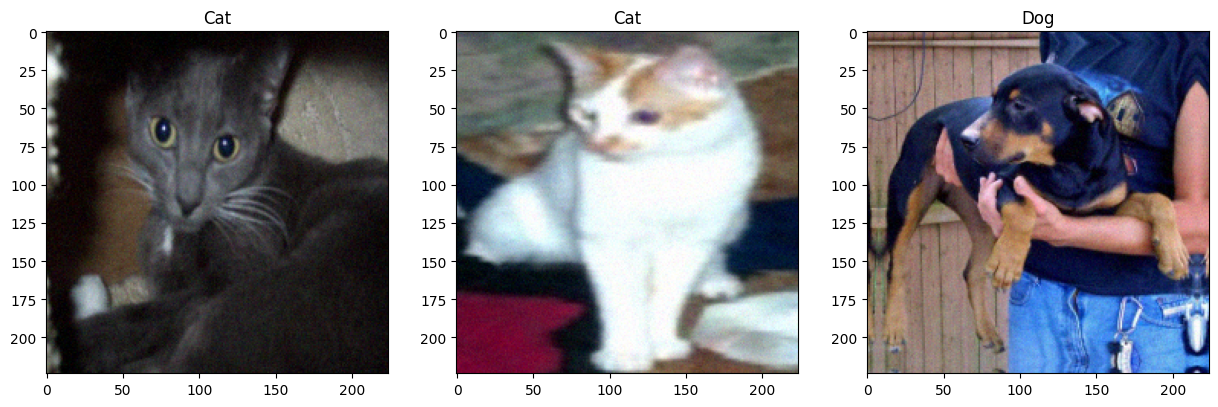

In [13]:
testing_len = 3
for i in range(testing_len):
    img, ann = next(dg_train)
    pyplot.subplot(1, testing_len, i+1)
    pyplot.imshow(img[0])
    label = 'Cat' if ann[0].argmax()==0 else 'Dog'
    pyplot.title(label=label)
pyplot.show()

### Stage 2

Creating universal size input neural network!

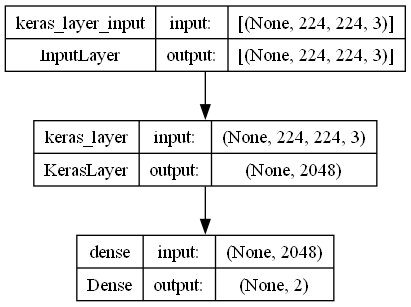

In [15]:
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='resnetV2_classificer_model.png', show_shapes=True, show_layer_names=True)

# Compiling model

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/model.ckpt', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True,  mode = 'max')

# Start FIT

In [17]:
history = model.fit(dg_train, steps_per_epoch=(cats_train+dogs_train)//bathsize, \
                    validation_data=dg_val, validation_steps=(cats_val+dogs_val)//bathsize, \
                    batch_size=bathsize, epochs=150, callbacks=[stopping, checkpoint])

Epoch 1/150
1403/1403 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9816
Epoch 1: val_accuracy improved from -inf to 0.98629, saving model to checkpoint\model.ckpt
1403/1403 [==============================] - 321s 221ms/step - loss: 0.0549 - accuracy: 0.9816 - val_loss: 0.0386 - val_accuracy: 0.9863
Epoch 2/150
1403/1403 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9875

KeyboardInterrupt: 

In [13]:
model.load_weights('checkpoint/model.ckpt')

ValueError: Received incompatible tensor with shape (32,) when attempting to restore variable with shape (16,) and name layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE.

Train Acc      0.9564326405525208
Validation Acc 0.9322580695152283


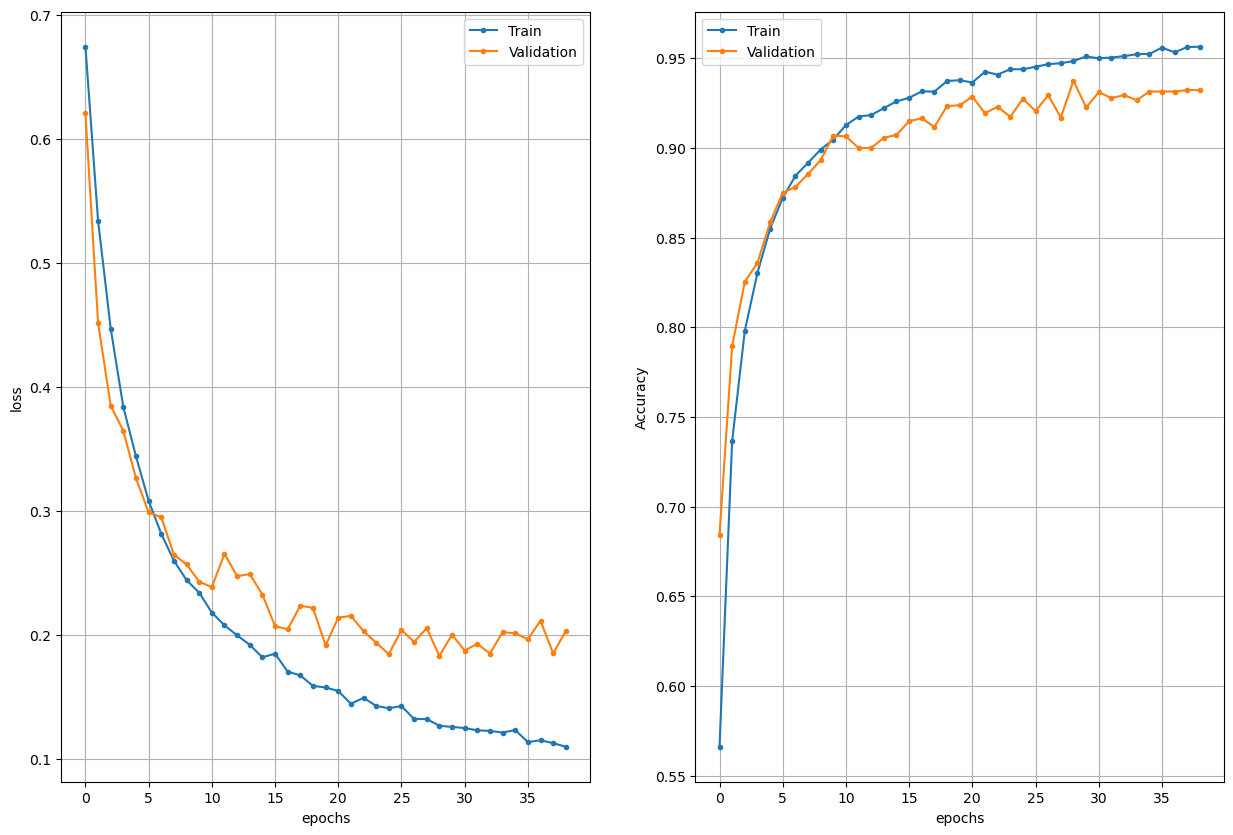

In [20]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    pyplot.subplot(1, 2, 1), pyplot.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    pyplot.grid(True), pyplot.xlabel('epochs'), pyplot.ylabel('loss')
    pyplot.legend(['Train', 'Validation'])
    pyplot.subplot(1, 2, 2), pyplot.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    pyplot.grid(True), pyplot.xlabel('epochs'), pyplot.ylabel('Accuracy')
    pyplot.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

In [18]:
# Save model
model.save('cat_vs_resnetV2__model')

INFO:tensorflow:Assets written to: cat_vs_resnetV2__model\assets


INFO:tensorflow:Assets written to: cat_vs_resnetV2__model\assets


In [ ]:
model: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_resnetV2__model', compile=False)
# for layer in model.layers:
#     layer.treniable = False
model.treniable = False
model.compile()
def load_image(filename: str):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
    img = img/img.max()
    img = img[:(img.shape[0]//32)*32, :(img.shape[1]//32)*32, :]
    img.shape = (1, img.shape[0], img.shape[1], 3)
    return img

1/1 [==============================] - 1s 1s/step


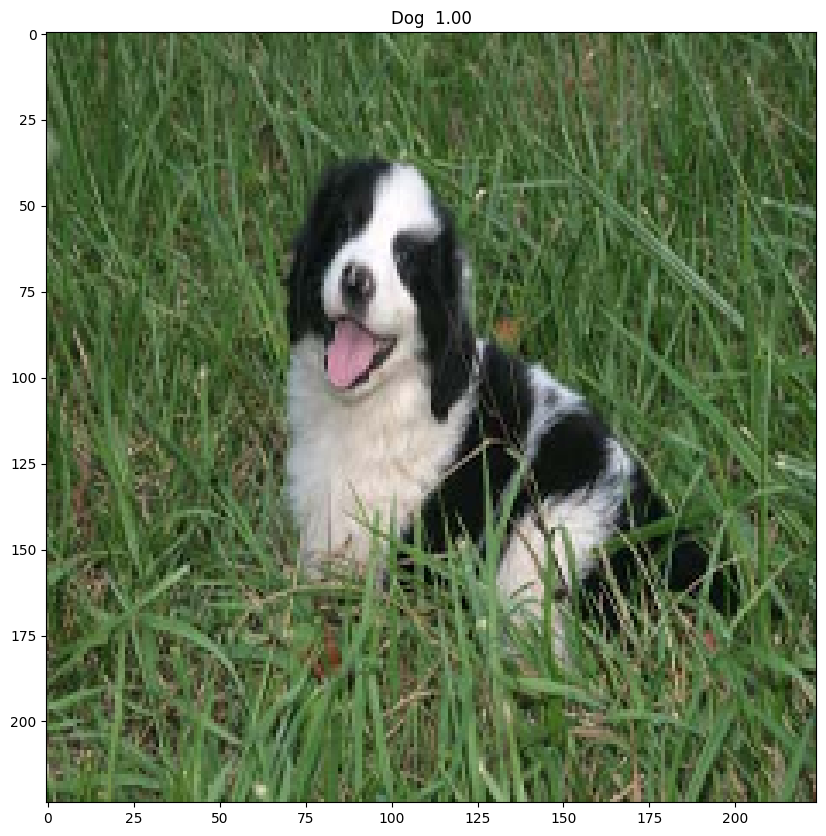

1/1 [==============================] - 0s 39ms/step


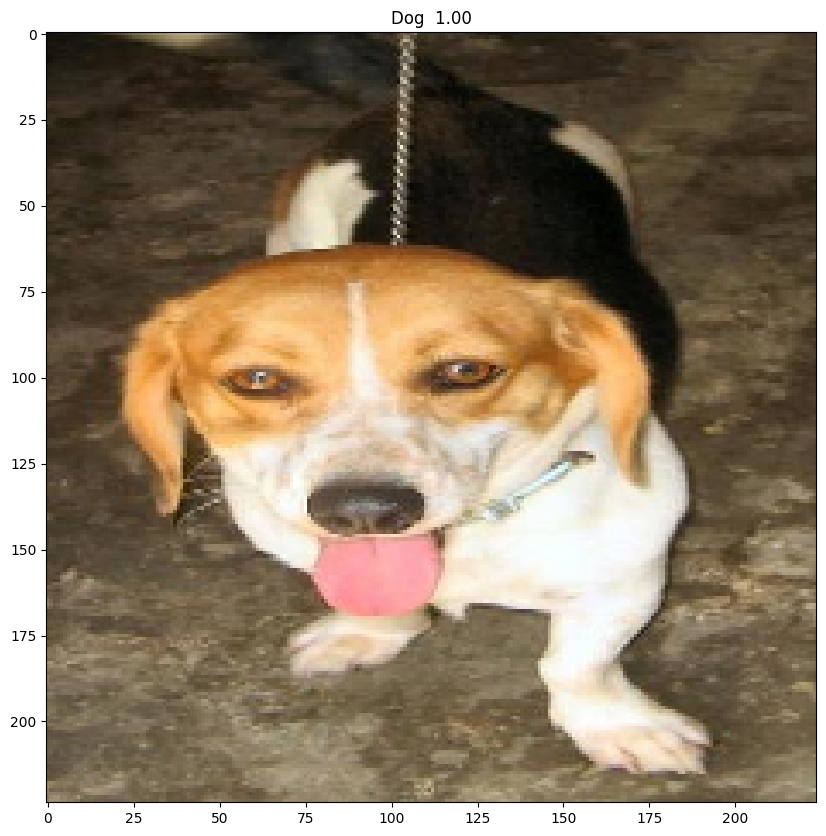

1/1 [==============================] - 0s 25ms/step


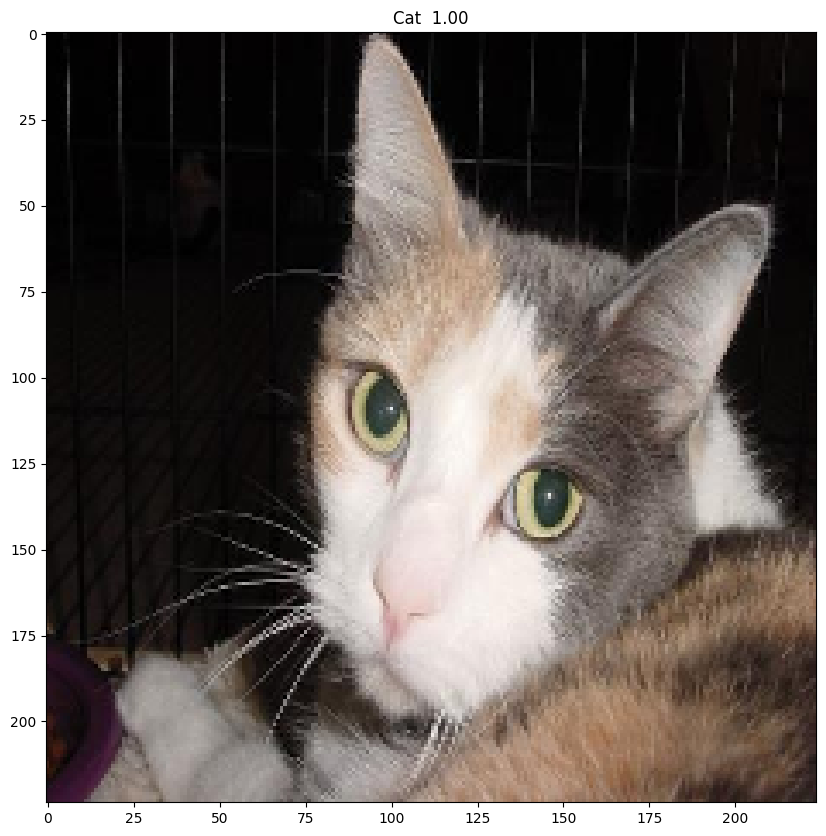

1/1 [==============================] - 0s 27ms/step


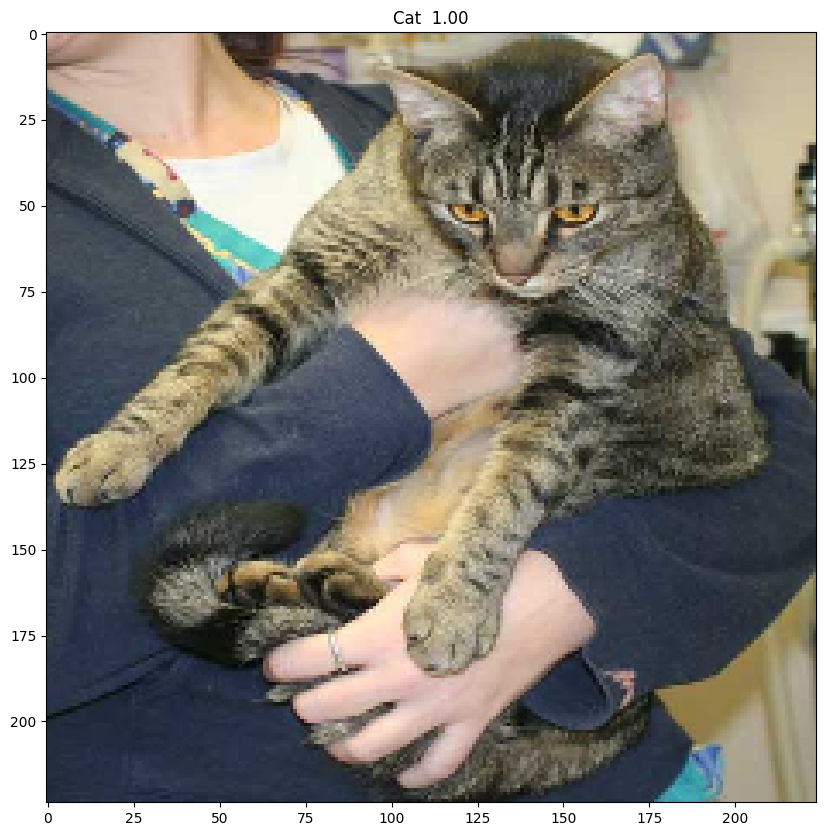

In [21]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
images = ['data/PetImages/Dog/12208.jpg', 'data/PetImages/Dog/12209.jpg', 'data/PetImages/Cat/12209.jpg', 'data/PetImages/Cat/12208.jpg']
for filename in images:
    img = load_image(filename) # [1, 224, 224, 3]
    pred = model.predict(img)
    class_name = 'Cat' if pred[0].argmax()==0 else 'Dog'
    propability = pred[0].max()
    pyplot.imshow(img[0])
    pyplot.title(f'{class_name}  {propability:.2f}')
    pyplot.show()

In [22]:
import time
test_bathsize = 128
dg_test = data_generator(cats_list=cats_list, dogs_list=dogs_list, bathsize=test_bathsize)
x, y = next(dg_test)
print(x.shape, y.shape)


(128, 224, 224, 3) (128, 2, 1)


In [23]:
repeats = 100
start_time = time.time()
for _ in range(repeats):
    _ = model.predict(x, verbose=3)
end_time = time.time()

print(f'{x.shape[0]*repeats} images with size (224x224) processed in {end_time-start_time:.3f} sec.')
print(f'{x.shape[0]*x.shape[1]*x.shape[2]*repeats/(end_time-start_time)/1000000:.3f} Mpixels processed per second.')

12800 images with size (224x224) processed in 45.703 sec.
14.053 Mpixels processed per second.


In [26]:
12800/46

278.2608695652174